<a href="https://colab.research.google.com/github/rahiakela/mlops-research-and-practice/blob/main/machine-learning-for-streaming-data/05_imbalanced_class_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
!pip install river

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import random

from river import anomaly

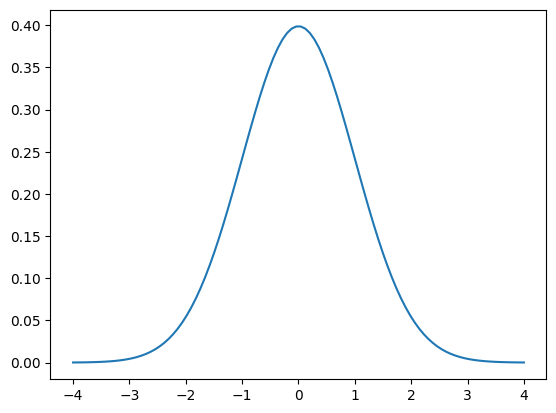

In [6]:
x = np.linspace(-4,4, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))

(array([6.000000e+00, 2.700000e+01, 1.290000e+02, 8.290000e+02,
        3.770000e+03, 1.471800e+04, 4.859500e+04, 1.357620e+05,
        3.168320e+05, 6.213720e+05, 1.022535e+06, 1.413836e+06,
        1.646252e+06, 1.605225e+06, 1.320665e+06, 9.106100e+05,
        5.273910e+05, 2.565330e+05, 1.051070e+05, 3.603400e+04,
        1.064000e+04, 2.511000e+03, 5.190000e+02, 8.500000e+01,
        1.700000e+01]),
 array([-5.40637829, -4.98620361, -4.56602892, -4.14585424, -3.72567955,
        -3.30550487, -2.88533018, -2.4651555 , -2.04498081, -1.62480613,
        -1.20463144, -0.78445676, -0.36428208,  0.05589261,  0.47606729,
         0.89624198,  1.31641666,  1.73659135,  2.15676603,  2.57694072,
         2.9971154 ,  3.41729009,  3.83746477,  4.25763946,  4.67781414,
         5.09798883]),
 <BarContainer object of 25 artists>)

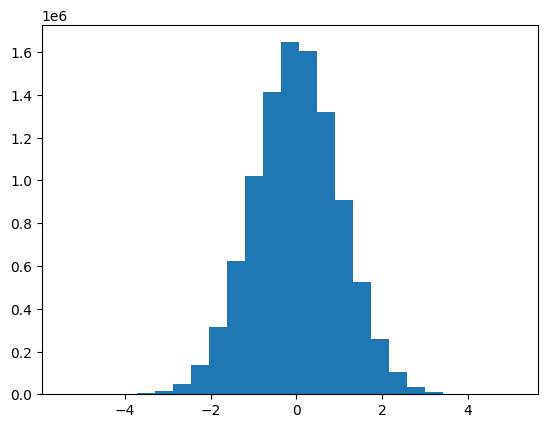

In [7]:
data = np.random.normal(size=10000000)
plt.hist(data, bins=25)

In [8]:
min(data), max(data)

(-5.406378291220651, 5.097988825180718)

##One-Class SVM

(array([103., 109.,  97.,  96.,  78.,  98., 110.,  98., 110., 101.]),
 array([2.02305790e-05, 9.99660869e-02, 1.99911943e-01, 2.99857800e-01,
        3.99803656e-01, 4.99749512e-01, 5.99695369e-01, 6.99641225e-01,
        7.99587081e-01, 8.99532937e-01, 9.99478794e-01]),
 <BarContainer object of 10 artists>)

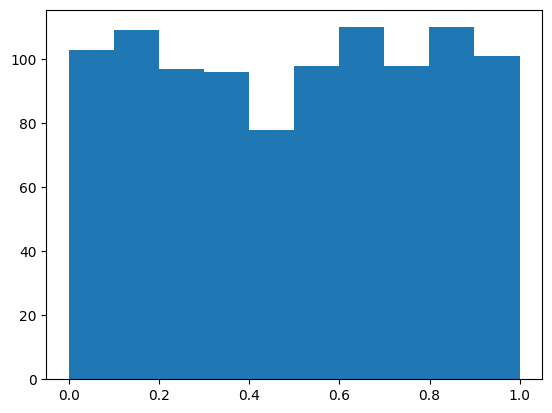

In [3]:
# Let's create a uniform distribution variable with 1,000 observations between 0 and 1
normal_data = np.random.rand(1000)

plt.hist(normal_data)

As we know, any data point between 0 and 1 is normal and every data point outside 0 to 1 is an outlier.

Let's now add 1% of outliers to the data. Let's make 0.5% of easy-to-detect outliers(random int between 2 and 3 and between -1 and -2), which is very far away from our normal distribution.

Let's also make 0.5% of our outliers a bit harder to detect
(between 0 and -1 and between 1 and 2).

In [9]:
hard_to_detect = list(np.random.uniform(1, 2, size=int(0.005 * 1000))) + list(np.random.uniform(1, -1, size=int(0.005 * 1000)))
easy_to_detect = list(np.random.uniform(2, 3, size=int(0.005 * 1000))) + list(np.random.uniform(-1, -2, size=int(0.005 * 1000)))

In [10]:
# Let's put all that data together and deliver it to the model in a streaming fashion
total_data = list(normal_data) + hard_to_detect + easy_to_detect

random.shuffle(total_data)

for dp in total_data:
  # Now, the only thing remaining to do is to add the model into the loop
  pass

In [24]:
# Anomaly percentage for the quantile thresholder
expected_percentage_anomaly = 20 / 1020
expected_percentage_normal = 1- expected_percentage_anomaly
expected_percentage_normal

0.9803921568627451

In [30]:
model = anomaly.QuantileFilter(anomaly.OneClassSVM(nu=0.2), q=expected_percentage_normal)
model

QuantileFilter (
  anomaly_detector=OneClassSVM (
    nu=0.2
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  q=0.980392
  protect_anomaly_detector=True
)

In [31]:
for dp in total_data:
  model.learn_one({"x": dp})

In [32]:
# Let's try to get an idea of how well it worked.
scores = []
for dp in total_data:
  scores.append(model.score_one({"x": dp}))

In [38]:
# As we know the actual result, we can now compare whether the answers were right
results = pd.DataFrame({"data": total_data, "score": scores})
results["actual_outlier"] = (results["data"] > 1) | (results["data"] < 0)

# there are 18 actual outliers
results["actual_outlier"].value_counts()

actual_outlier
False    1002
True       18
Name: count, dtype: int64

In [39]:
# the algo detected 22 outliers
results["score"].value_counts()

score
0.013740    1
0.016074    1
0.062054    1
0.034243    1
0.050274    1
           ..
0.065390    1
0.015670    1
0.038987    1
0.033987    1
0.087190    1
Name: count, Length: 1020, dtype: int64

In [40]:
# We should now compute how many of the detected outliers are actual outliers and how many are not actual outliers.
results.groupby("actual_outlier")["score"].sum()  # in the 22 detected otuliuers, 10 are actual outliers, but 12 are not actually outliers

actual_outlier
False    47.746312
True      1.003730
Name: score, dtype: float64

##Half-Space-Trees